# tnc-edge-vectorprocessing

This notebook analyses the performance of vectors on the edge. This is done by looking at the datetimes of all vector outputs and comparing their actual runtimes with the expected runtime. 

This notebook also pulls in the THALOS Certus uptime logs, which should indicate when the system is on. The datasets are compared, showing uptime when they agree and highlighting inconsistencies when they disagree.

This analysis is run seperately for each vector_id because each vector_id runs on a different scheduled interval.

In [181]:
# aws_config = {
# 'aws_access_key_id':'XXXXXXXX',
# 'aws_secret_access_key':'XXXXXXXX',
# 'aws_session_token':'XXXXXXXX='
# }

aws_config = {}

aws_config['profile_name'] ='XXXXXXXX'
aws_config['region_name'] = 'us-east-1'

import boto3

boto3.setup_default_session(**aws_config)

s3 = boto3.client('s3')

# s3.list_objects(Bucket='51-gema-dev-dp-raw' , Prefix='tnc_edge/')

import pandas
import numpy
import math
import awswrangler
from datetime import datetime, timezone, timedelta
from dateutil import parser
import pytz

def display_full(x):
    pandas.set_option('display.max_rows', 5000)
    pandas.set_option('display.min_rows', 1000)
    pandas.set_option('display.max_columns', None)
    pandas.set_option('display.width', 2000)
    pandas.set_option('display.float_format', '{:20,.2f}'.format)
    pandas.set_option('display.max_colwidth', None)
    display(x)
    pandas.reset_option('display.max_rows')
    pandas.reset_option('display.max_columns')
    pandas.reset_option('display.width')
    pandas.reset_option('display.float_format')
    pandas.reset_option('display.max_colwidth')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [182]:
branc_equip_agg_df = awswrangler.athena.read_sql_query(f"SELECT * from brancol_v1_tests where datetime > '2024-01-01' and vector_id='4'", database='tnc_edge')
# equip_agg_df = awswrangler.athena.read_sql_query(f"SELECT * from brancol_v1_tests where vector_id = '4' limit 10", database='tnc_edge')
branc_equip_agg_df['datetime'] = pandas.to_datetime(branc_equip_agg_df['datetime'], utc=True)

branc_equip_agg_df = branc_equip_agg_df.sort_values('datetime')


In [183]:
stpat_equip_agg_df = awswrangler.athena.read_sql_query(f"SELECT * from stpatrick_v1_tests where datetime > '2024-01-01' and vector_id='4'", database='tnc_edge')
# equip_agg_df = awswrangler.athena.read_sql_query(f"SELECT * from brancol_v1_tests where vector_id = '4' limit 10", database='tnc_edge')
stpat_equip_agg_df['datetime'] = pandas.to_datetime(stpat_equip_agg_df['datetime'], utc=True)

stpat_equip_agg_df = stpat_equip_agg_df.sort_values('datetime')


In [184]:
display(stpat_equip_agg_df)

,id,name,type,vector_id,score,detail,datetime,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2
14,7116,equipment outage aggregator from 2024-01-03 16...,<NA>,4,0.0049751243781093,"vector_id=score: 3=0.0, 1=0.004975124378109319",2024-01-03 20:27:31.552398+00:00,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12
15,7210,equipment outage aggregator from 2024-01-03 20...,<NA>,4,0.0049751243781093,"vector_id=score: 1=0.0, 3=0.004975124378109319",2024-01-04 00:27:31.682645+00:00,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12
16,7304,equipment outage aggregator from 2024-01-04 00...,<NA>,4,0.0099009900990099,"vector_id=score: 1=0.00990099009900991, 3=0.0",2024-01-04 04:27:31.733690+00:00,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12
17,7397,equipment outage aggregator from 2024-01-04 04...,<NA>,4,0.0099009900990099,"vector_id=score: 1=0.00990099009900991, 3=0.0",2024-01-04 08:27:31.844514+00:00,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12
18,7491,equipment outage aggregator from 2024-01-04 08...,<NA>,4,0.0,"vector_id=score: 1=0.0, 3=0.0",2024-01-04 12:27:31.960635+00:00,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12
19,7585,equipment outage aggregator from 2024-01-04 12...,<NA>,4,0.0430622009569376,"vector_id=score: 1=0.04306220095693769, 3=0.0",2024-01-04 16:27:31.997374+00:00,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12
20,7677,equipment outage aggregator from 2024-01-04 16...,<NA>,4,0.0384615384615385,"vector_id=score: 1=0.03846153846153855, 3=0.0",2024-01-04 20:27:32.089588+00:00,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12
21,7771,equipment outage aggregator from 2024-01-04 20...,<NA>,4,0.0,"vector_id=score: 3=0.0, 1=0.0",2024-01-05 00:27:32.212241+00:00,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12
22,7865,equipment outage aggregator from 2024-01-05 00...,<NA>,4,0.0,"vector_id=score: 3=0.0, 1=0.0",2024-01-05 04:27:32.283015+00:00,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12
8,7971,equipment outage aggregator from 2024-01-12 21...,<NA>,4,0.7191011235955056,"vector_id=score: 3=0.7191011235955056, 1=0.043...",2024-01-13 01:34:02.880273+00:00,<NA>,<NA>,2024-01-13 12:44:42,2024/1/13/1705149868-0.csv,7f8b4cec-be2c-463e-a5c9-07ad9f21511e,2024,1,13


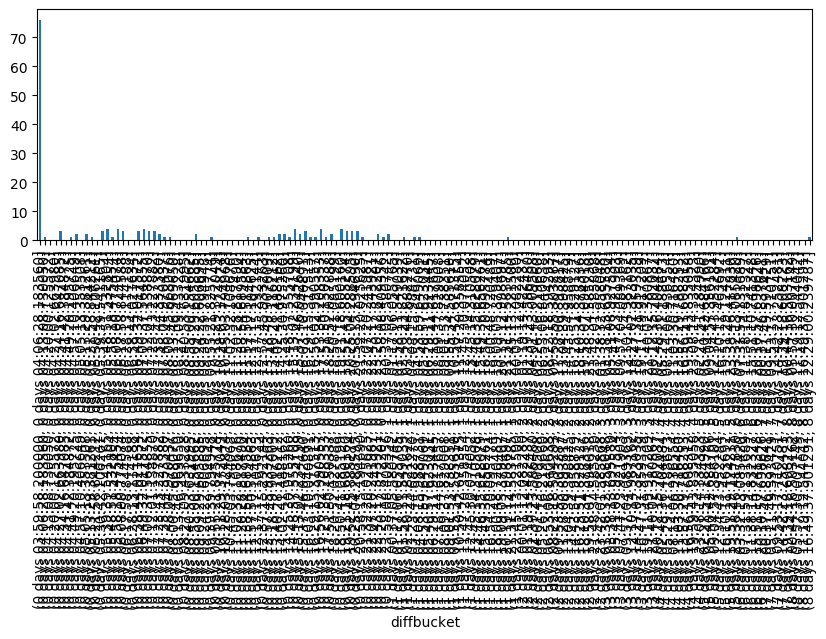

In [185]:
branc_equip_agg_df['diff'] = branc_equip_agg_df['datetime'] - branc_equip_agg_df.shift(1)['datetime']
# branc_equip_agg_df

min_lateness = 3.9995*60
bins = numpy.logspace(math.log(min_lateness,10), math.log(1+branc_equip_agg_df['diff'].map(lambda x: x.total_seconds()/60).max(),10), num=150)
# bins = numpy.logspace(math.log(min_lateness,10), math.log(4.0005*60,10), num=50)
bins = list(map(lambda x: timedelta(minutes=x), bins))
bins
branc_equip_agg_df['diffbucket'] = pandas.cut(branc_equip_agg_df.loc[branc_equip_agg_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
branc_equip_agg_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))



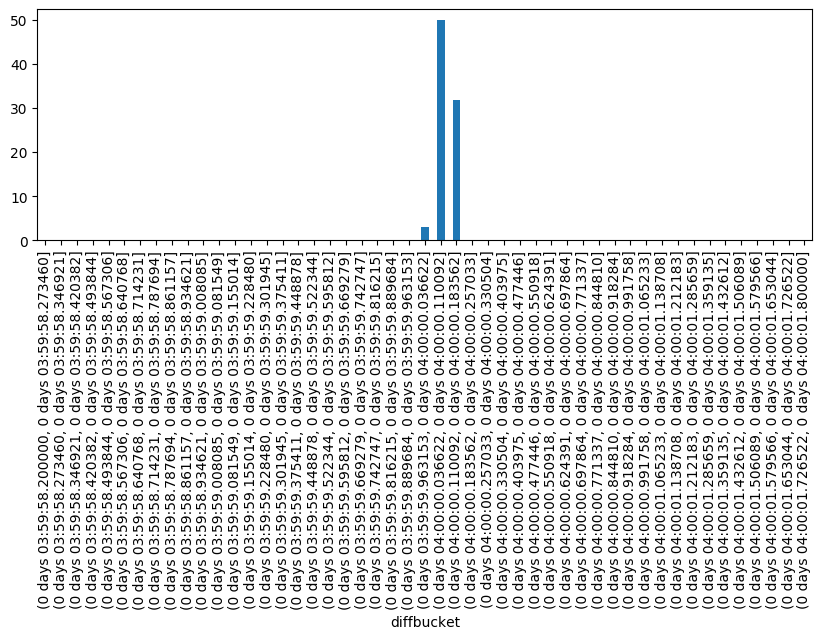

In [186]:
stpat_equip_agg_df['diff'] = stpat_equip_agg_df['datetime'] - stpat_equip_agg_df.shift(1)['datetime']
# branc_equip_agg_df

# min_lateness=3.9*60
min_lateness = 3.9995*60
bins = numpy.logspace(math.log(min_lateness,10), math.log(1+stpat_equip_agg_df['diff'].map(lambda x: x.total_seconds()/60).max(),10), num=150)
bins = numpy.logspace(math.log(min_lateness,10), math.log(4.0005*60,10), num=50)
bins = list(map(lambda x: timedelta(minutes=x), bins))
bins
stpat_equip_agg_df['diffbucket'] = pandas.cut(stpat_equip_agg_df.loc[stpat_equip_agg_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
stpat_equip_agg_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))



In [187]:
# stpat_equip_agg_df = awswrangler.athena.read_sql_query(f"SELECT * from stpatrick_v1_tests where datetime > '2024-01-01' and vector_id='4'", database='tnc_edge')
branc_thalosmount_df = awswrangler.athena.read_sql_query(f"SELECT * from brancol_v1_tests where vector_id = '3'", database='tnc_edge')
branc_thalosmount_df['datetime'] = pandas.to_datetime(branc_thalosmount_df['datetime'], utc=True)
branc_thalosmount_df = branc_thalosmount_df.sort_values('datetime')

stpat_thalosmount_df = awswrangler.athena.read_sql_query(f"SELECT * from stpatrick_v1_tests where vector_id = '3'", database='tnc_edge')
stpat_thalosmount_df['datetime'] = pandas.to_datetime(stpat_thalosmount_df['datetime'], utc=True)
stpat_thalosmount_df = stpat_thalosmount_df.sort_values('datetime')

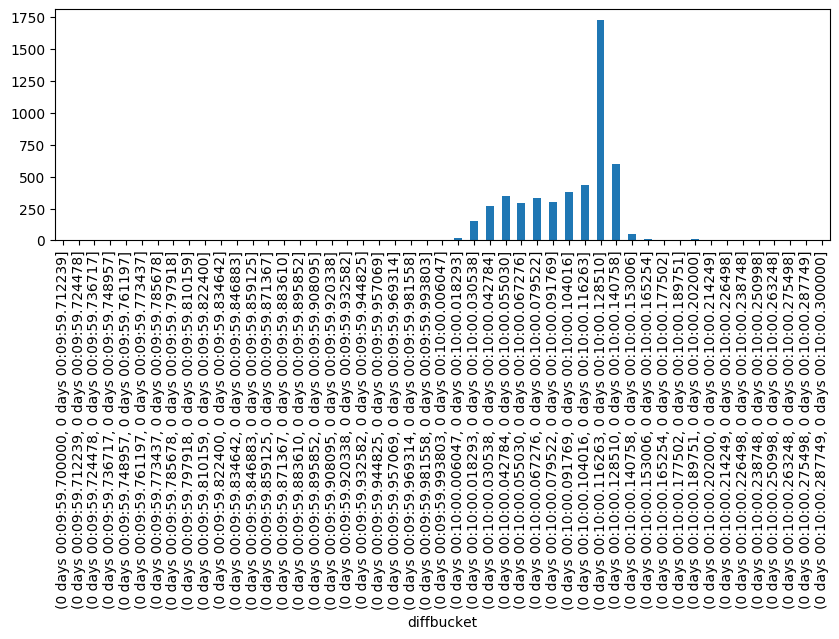

In [188]:
branc_thalosmount_df['diff'] = branc_thalosmount_df['datetime'] - branc_thalosmount_df.shift(1)['datetime']
stpat_thalosmount_df['diff'] = stpat_thalosmount_df['datetime'] - stpat_thalosmount_df.shift(1)['datetime']

min_lateness = 9.995
bins = numpy.logspace(math.log(min_lateness,10), math.log(1+stpat_thalosmount_df['diff'].map(lambda x: x.total_seconds()/60).max(),10), num=120)
bins = numpy.logspace(math.log(min_lateness,10), math.log(10.005,10), num=50)
bins = list(map(lambda x: timedelta(minutes=x), bins))
bins
stpat_thalosmount_df['diffbucket'] = pandas.cut(stpat_thalosmount_df.loc[stpat_thalosmount_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
stpat_thalosmount_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))
branc_thalosmount_df['diffbucket'] = pandas.cut(branc_thalosmount_df.loc[branc_thalosmount_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
# branc_thalosmount_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))



In [189]:
thaloslogs_stpatrick_isup = pandas.read_pickle('thaloslogs_stpatrick_uptime_ts_df.pickle')
# thaloslogs_stpatrick_isup = thaloslogs_stpatrick_uptime_ts_df.loc[thaloslogs_stpatrick_uptime_ts_df['up'] == 1]
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.loc[thaloslogs_stpatrick_isup.index < '2024-04-08']
thaloslogs_stpatrick_isup.sort_index()
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.resample(timedelta(minutes=10))[['up']].min()
thaloslogs_stpatrick_isup

stpat_thalosmount_ts_df = stpat_thalosmount_df.set_index('datetime')
# stpat_thalosmount_ts_df = stpat_thalosmount_ts_df.resample(timedelta(minutes=5)).last()
stpat_thalosmount_ts_df = stpat_thalosmount_ts_df.resample(timedelta(minutes=10)).last()
display()
stpat_thalosmount_ts_df = stpat_thalosmount_ts_df.loc[stpat_thalosmount_ts_df.index >= thaloslogs_stpatrick_isup.index[0]]
stpat_thalosmount_ts_df = stpat_thalosmount_ts_df.join(thaloslogs_stpatrick_isup[['up']] , how='outer')

# stpat_thalosmount_ts_df.loc[ ( stpat_thalosmount_ts_df['id'].notna() ) & ( stpat_thalosmount_ts_df['up'] == 1 ) ]

print('off, no vector', (( stpat_thalosmount_ts_df['id'].isna() ) & ( stpat_thalosmount_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( stpat_thalosmount_ts_df['id'].notna() ) & ( stpat_thalosmount_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( stpat_thalosmount_ts_df['id'].isna() ) & ( stpat_thalosmount_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( stpat_thalosmount_ts_df['id'].notna() ) & ( stpat_thalosmount_ts_df['up'] == 1 )).sum())
print('total on', (( stpat_thalosmount_ts_df['up'] == 1 )).sum())

stpat_thalosmount_ts_df['prevup'] = stpat_thalosmount_ts_df['up'].shift(1)
display(stpat_thalosmount_ts_df.loc[(( stpat_thalosmount_ts_df['id'].isna() ) & (( stpat_thalosmount_ts_df['up'] == 1 )) | ( stpat_thalosmount_ts_df['up'] != stpat_thalosmount_ts_df['prevup'] ) ) ])

off, no vector 6446
off, vector ran somehow? 478
on, no vector? 814
on, vector worked. 6209
total on 7023


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,NaN
2024-01-02 18:50:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-02 19:00:00+00:00,6956,"thalos mounted network dir, run at 2024-01-02 ...",<NA>,3,0.0,<NA>,<NA>,<NA>,2024-01-03 15:13:56,2024/1/3/1704294826-0.csv,e2d23f44-a544-470d-bc3f-d76b6ef18351,2024,1,3,0 days 00:20:00.172675,NaN,0,1.0
2024-01-03 13:20:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-03 16:20:00+00:00,7032,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,0.0,<NA>,<NA>,<NA>,2024-01-03 17:28:15,2024/1/3/1704302883-0.csv,9b14a4bd-548b-4207-98fe-565e65bfa33f,2024,1,3,0 days 00:13:50.332638,NaN,0,1.0
2024-01-03 16:30:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-03 22:00:00+00:00,7158,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,0.0,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:10:00.128057,"(0 days 00:10:00.116263, 0 days 00:10:00.128510]",0,1.0
2024-01-03 22:10:00+00:00,7161,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,0.0,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:10:00.117618,"(0 days 00:10:00.116263, 0 days 00:10:00.128510]",1,0.0
2024-01-03 22:50:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,1.0


In [190]:
thaloslogs_brancol_isup = pandas.read_pickle('thaloslogs_brancol_uptime_ts_df.pickle')
# thaloslogs_brancol_isup = thaloslogs_brancol_uptime_ts_df.loc[thaloslogs_brancol_uptime_ts_df['up'] == 1]
thaloslogs_brancol_isup = thaloslogs_brancol_isup.loc[thaloslogs_brancol_isup.index < '2024-04-08']
thaloslogs_brancol_isup.sort_index()
thaloslogs_brancol_isup = thaloslogs_brancol_isup.resample(timedelta(minutes=10))[['up']].min()
thaloslogs_brancol_isup

branc_thalosmount_ts_df = branc_thalosmount_df.set_index('datetime')
# branc_thalosmount_ts_df = branc_thalosmount_ts_df.resample(timedelta(minutes=5)).last()
branc_thalosmount_ts_df = branc_thalosmount_ts_df.resample(timedelta(minutes=10)).last()
display()
branc_thalosmount_ts_df = branc_thalosmount_ts_df.loc[branc_thalosmount_ts_df.index >= thaloslogs_brancol_isup.index[0]]
branc_thalosmount_ts_df = branc_thalosmount_ts_df.join(thaloslogs_brancol_isup[['up']] , how='outer')

# branc_thalosmount_ts_df.loc[ ( branc_thalosmount_ts_df['id'].notna() ) & ( branc_thalosmount_ts_df['up'] == 1 ) ]

print('off, no vector', (( branc_thalosmount_ts_df['id'].isna() ) & ( branc_thalosmount_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( branc_thalosmount_ts_df['id'].notna() ) & ( branc_thalosmount_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( branc_thalosmount_ts_df['id'].isna() ) & ( branc_thalosmount_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( branc_thalosmount_ts_df['id'].notna() ) & ( branc_thalosmount_ts_df['up'] == 1 )).sum())
print('total on', (( branc_thalosmount_ts_df['up'] == 1 )).sum())

branc_thalosmount_ts_df['prevup'] = branc_thalosmount_ts_df['up'].shift(1)
display(branc_thalosmount_ts_df.loc[(( branc_thalosmount_ts_df['id'].isna() ) & (( branc_thalosmount_ts_df['up'] == 1 )) | ( branc_thalosmount_ts_df['up'] != branc_thalosmount_ts_df['prevup'] ) ) ])

off, no vector 7230
off, vector ran somehow? 167
on, no vector? 1234
on, vector worked. 5481
total on 6715


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,NaN
2024-01-03 15:50:00+00:00,17992,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,0.0,<NA>,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,4 days 01:00:12.347257,NaN,1,0.0
2024-01-03 16:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,1.0
2024-01-03 17:20:00+00:00,18021,"thalos mounted network dir, run at 2024-01-03 ...",<NA>,3,0.0,<NA>,<NA>,<NA>,2024-01-04 16:22:10,2024/1/4/1704385322-0.csv,831dcf96-e6af-4a22-84d1-7e616e231d53,2024,1,4,0 days 00:10:11.481568,NaN,0,1.0
2024-01-04 15:20:00+00:00,18023,"thalos mounted network dir, run at 2024-01-04 ...",<NA>,3,0.0,<NA>,<NA>,<NA>,2024-01-04 16:22:10,2024/1/4/1704385322-0.csv,831dcf96-e6af-4a22-84d1-7e616e231d53,2024,1,4,0 days 21:59:25.958669,NaN,1,0.0
2024-01-04 15:30:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,1.0
2024-01-04 17:20:00+00:00,18064,"thalos mounted network dir, run at 2024-01-04 ...",<NA>,3,<NA>,<NA>,<NA>,<NA>,2024-01-04 17:21:58,2024/1/4/1704388906-0.csv,fba2b974-8656-4e31-8d2c-a8ed99a10bcf,2024,1,4,0 days 00:10:09.766240,NaN,0,1.0
2024-01-05 15:50:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-05 16:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,1.0


In [191]:
# off, no vector 6446
# off, vector ran somehow? 478
# on, no vector? 814
# on, vector worked. 6209
# total on 7023

# stpat 627 during 5th-12th downtime



# off, no vector 7230
# off, vector ran somehow? 167
# on, no vector? 1234
# on, vector worked. 5481
# total on 6715

# branc 1013 during 5th-12th downtime

(6209 + 5481) / (7023 - 627 + 6715 - 1013)

0.9662754174243676

In [192]:
branc_gpstest_df = awswrangler.athena.read_sql_query(f"SELECT * from brancol_v1_tests where vector_id = '2'", database='tnc_edge')
branc_gpstest_df['datetime'] = pandas.to_datetime(branc_gpstest_df['datetime'], utc=True)
branc_gpstest_df = branc_gpstest_df.sort_values('datetime')

stpat_gpstest_df = awswrangler.athena.read_sql_query(f"SELECT * from stpatrick_v1_tests where vector_id = '2'", database='tnc_edge')
stpat_gpstest_df['datetime'] = pandas.to_datetime(stpat_gpstest_df['datetime'], utc=True)
stpat_gpstest_df = stpat_gpstest_df.sort_values('datetime')

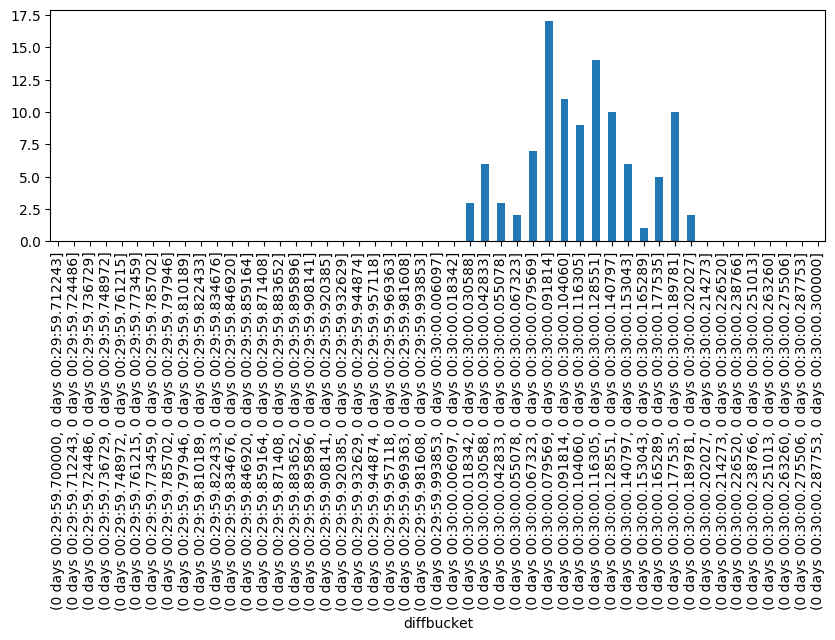

In [193]:
branc_gpstest_df['diff'] = branc_gpstest_df['datetime'] - branc_gpstest_df.shift(1)['datetime']
stpat_gpstest_df['diff'] = stpat_gpstest_df['datetime'] - stpat_gpstest_df.shift(1)['datetime']

min_lateness = 29.995
bins = numpy.logspace(math.log(min_lateness,10), math.log(1+stpat_gpstest_df['diff'].map(lambda x: x.total_seconds()/60).max(),10), num=120)
bins = numpy.logspace(math.log(min_lateness,10), math.log(30.005,10), num=50)
bins = list(map(lambda x: timedelta(minutes=x), bins))
bins
stpat_gpstest_df['diffbucket'] = pandas.cut(stpat_gpstest_df.loc[stpat_gpstest_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
stpat_gpstest_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))
branc_gpstest_df['diffbucket'] = pandas.cut(branc_gpstest_df.loc[branc_gpstest_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
# branc_gpstest_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))



In [194]:
thaloslogs_brancol_isup = pandas.read_pickle('thaloslogs_brancol_uptime_ts_df.pickle')
# thaloslogs_brancol_isup = thaloslogs_brancol_uptime_ts_df.loc[thaloslogs_brancol_uptime_ts_df['up'] == 1]
thaloslogs_brancol_isup = thaloslogs_brancol_isup.loc[thaloslogs_brancol_isup.index < '2024-04-08']
thaloslogs_brancol_isup.sort_index()
thaloslogs_brancol_isup = thaloslogs_brancol_isup.resample(timedelta(minutes=30))[['up']].max()
thaloslogs_brancol_isup

branc_gpstest_ts_df = branc_gpstest_df.set_index('datetime')
# branc_gpstest_ts_df = branc_gpstest_ts_df.resample(timedelta(minutes=5)).last()
branc_gpstest_ts_df = branc_gpstest_ts_df.resample(timedelta(minutes=30)).last()
display()
branc_gpstest_ts_df = branc_gpstest_ts_df.loc[branc_gpstest_ts_df.index >= thaloslogs_brancol_isup.index[0]]
branc_gpstest_ts_df = branc_gpstest_ts_df.join(thaloslogs_brancol_isup[['up']] , how='outer')

# branc_gpstest_ts_df.loc[ ( branc_gpstest_ts_df['id'].notna() ) & ( branc_gpstest_ts_df['up'] == 1 ) ]

print('off, no vector', (( branc_gpstest_ts_df['id'].isna() ) & ( branc_gpstest_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( branc_gpstest_ts_df['id'].notna() ) & ( branc_gpstest_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( branc_gpstest_ts_df['id'].isna() ) & ( branc_gpstest_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( branc_gpstest_ts_df['id'].notna() ) & ( branc_gpstest_ts_df['up'] == 1 )).sum())
print('total on', (( branc_gpstest_ts_df['up'] == 1 )).sum())

branc_gpstest_ts_df['prevup'] = branc_gpstest_ts_df['up'].shift(1)
display(branc_gpstest_ts_df.loc[(( branc_gpstest_ts_df['id'].isna() ) & (( branc_gpstest_ts_df['up'] == 1 )) | ( branc_gpstest_ts_df['up'] != branc_gpstest_ts_df['prevup'] ) ) ])

off, no vector 2360
off, vector ran somehow? 3
on, no vector? 493
on, vector worked. 1848
total on 2341


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,NaN
2024-01-03 15:30:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-03 17:30:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,1.0
2024-01-03 18:30:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-03 19:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,1.0
2024-01-04 15:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-04 17:30:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,1.0
2024-01-05 15:30:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-05 19:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,1.0


In [195]:
thaloslogs_stpatrick_isup = pandas.read_pickle('thaloslogs_stpatrick_uptime_ts_df.pickle')
# thaloslogs_stpatrick_isup = thaloslogs_stpatrick_uptime_ts_df.loc[thaloslogs_stpatrick_uptime_ts_df['up'] == 1]
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.loc[thaloslogs_stpatrick_isup.index < '2024-04-08']
thaloslogs_stpatrick_isup.sort_index()
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.resample(timedelta(minutes=30))[['up']].min()
thaloslogs_stpatrick_isup

stpat_gpstest_ts_df = stpat_gpstest_df.set_index('datetime')
# stpat_gpstest_ts_df = stpat_gpstest_ts_df.resample(timedelta(minutes=5)).last()
stpat_gpstest_ts_df = stpat_gpstest_ts_df.resample(timedelta(minutes=30)).last()
display()
stpat_gpstest_ts_df = stpat_gpstest_ts_df.loc[stpat_gpstest_ts_df.index >= thaloslogs_stpatrick_isup.index[0]]
stpat_gpstest_ts_df = stpat_gpstest_ts_df.join(thaloslogs_stpatrick_isup[['up']] , how='outer')

# stpat_gpstest_ts_df.loc[ ( stpat_gpstest_ts_df['id'].notna() ) & ( stpat_gpstest_ts_df['up'] == 1 ) ]

print('off, no vector', (( stpat_gpstest_ts_df['id'].isna() ) & ( stpat_gpstest_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( stpat_gpstest_ts_df['id'].notna() ) & ( stpat_gpstest_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( stpat_gpstest_ts_df['id'].isna() ) & ( stpat_gpstest_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( stpat_gpstest_ts_df['id'].notna() ) & ( stpat_gpstest_ts_df['up'] == 1 )).sum())
print('total on', (( stpat_gpstest_ts_df['up'] == 1 )).sum())

stpat_gpstest_ts_df['prevup'] = stpat_gpstest_ts_df['up'].shift(1)
display(stpat_gpstest_ts_df.loc[(( stpat_gpstest_ts_df['id'].isna() ) & (( stpat_gpstest_ts_df['up'] == 1 )) | ( stpat_gpstest_ts_df['up'] != stpat_gpstest_ts_df['prevup'] ) ) ])

off, no vector 2254
off, vector ran somehow? 193
on, no vector? 217
on, vector worked. 1985
total on 2202


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,NaN
2024-01-03 13:30:00+00:00,6970,gps test from 2024-01-03 05:08:15.857553-08:00...,<NA>,2,0.0,<NA>,2024-01-03 05:08:15.857553-08,2024-01-03 05:42:42.960352-08,2024-01-03 15:13:56,2024/1/3/1704294826-0.csv,e2d23f44-a544-470d-bc3f-d76b6ef18351,2024,1,3,0 days 00:34:27.101776,NaN,1,0.0
2024-01-03 16:00:00+00:00,7028,gps test from 2024-01-03 07:43:30.947958-08:00...,<NA>,2,0.0,<NA>,2024-01-03 07:43:30.947958-08,2024-01-03 08:13:41.086953-08,2024-01-03 17:28:15,2024/1/3/1704302883-0.csv,9b14a4bd-548b-4207-98fe-565e65bfa33f,2024,1,3,0 days 00:30:10.139609,NaN,0,1.0
2024-01-03 16:30:00+00:00,7037,gps test from 2024-01-03 08:13:41.086953-08:00...,<NA>,2,0.0,<NA>,2024-01-03 08:13:41.086953-08,2024-01-03 08:57:42.370191-08,2024-01-03 17:28:15,2024/1/3/1704302883-0.csv,9b14a4bd-548b-4207-98fe-565e65bfa33f,2024,1,3,0 days 00:44:01.282594,NaN,1,0.0
2024-01-03 22:00:00+00:00,7166,gps test from 2024-01-03 13:59:41.439869-08:00...,<NA>,2,0.0,<NA>,2024-01-03 13:59:41.439869-08,2024-01-03 14:29:51.657302-08,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:30:10.217360,NaN,0,1.0
2024-01-03 22:30:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-04 08:00:00+00:00,7388,gps test from 2024-01-03 23:33:21.167213-08:00...,<NA>,2,0.0,<NA>,2024-01-03 23:33:21.167213-08,2024-01-04 00:03:49.587593-08,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:30:28.403793,NaN,0,1.0
2024-01-04 08:30:00+00:00,7402,gps test from 2024-01-04 00:03:49.587593-08:00...,<NA>,2,0.0,<NA>,2024-01-04 00:03:49.587593-08,2024-01-04 00:34:02.136077-08,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:30:12.548463,NaN,1,0.0
2024-01-05 05:00:00+00:00,7883,gps test from 2024-01-04 20:41:33.208929-08:00...,<NA>,2,0.0,<NA>,2024-01-04 20:41:33.208929-08,2024-01-04 21:11:44.657983-08,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:30:11.449013,NaN,0,1.0


In [196]:
# off, no vector 2481
# off, vector ran somehow? 75
# on, no vector? 372
# on, vector worked. 1776
# total on 2148

# 336 during 5th-12th downtime


# off, no vector 2254
# off, vector ran somehow? 193
# on, no vector? 217
# on, vector worked. 1985
# total on 2202

# 207 during 5th-12th downtime


(1776 + 1985 ) / ( 2148 - 336 + 2202 - 207)

0.9879169950091936

In [197]:
branc_inettest_df = awswrangler.athena.read_sql_query(f"SELECT * from brancol_v1_tests where vector_id = '1'", database='tnc_edge')
# branc_inettest_df
branc_inettest_df['datetime'] = pandas.to_datetime(branc_inettest_df['datetime'], utc=True)
branc_inettest_df = branc_inettest_df.sort_values('datetime')

stpat_inettest_df = awswrangler.athena.read_sql_query(f"SELECT * from stpatrick_v1_tests where vector_id = '1'", database='tnc_edge')
stpat_inettest_df['datetime'] = pandas.to_datetime(stpat_inettest_df['datetime'], utc=True)
stpat_inettest_df = stpat_inettest_df.sort_values('datetime')

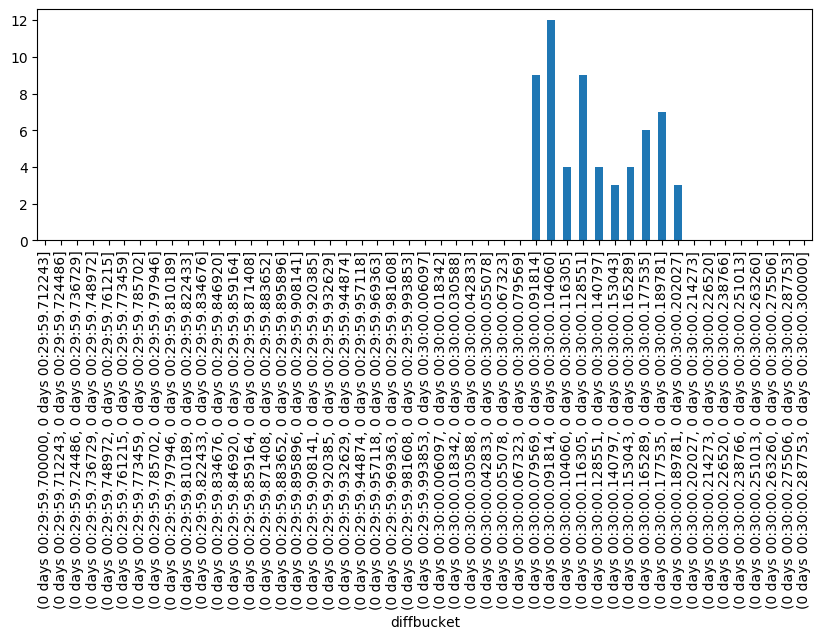

In [198]:
branc_inettest_df['diff'] = branc_inettest_df['datetime'] - branc_inettest_df.shift(1)['datetime']
stpat_inettest_df['diff'] = stpat_inettest_df['datetime'] - stpat_inettest_df.shift(1)['datetime']

min_lateness = 29.995
bins = numpy.logspace(math.log(min_lateness,10), math.log(1+stpat_inettest_df['diff'].map(lambda x: x.total_seconds()/60).max(),10), num=120)
bins = numpy.logspace(math.log(min_lateness,10), math.log(30.005,10), num=50)
bins = list(map(lambda x: timedelta(minutes=x), bins))
bins
stpat_inettest_df['diffbucket'] = pandas.cut(stpat_inettest_df.loc[stpat_inettest_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
stpat_inettest_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))
branc_inettest_df['diffbucket'] = pandas.cut(branc_inettest_df.loc[branc_inettest_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
# branc_inettest_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))



In [199]:
thaloslogs_stpatrick_isup = pandas.read_pickle('thaloslogs_stpatrick_uptime_ts_df.pickle')
# thaloslogs_stpatrick_isup = thaloslogs_stpatrick_uptime_ts_df.loc[thaloslogs_stpatrick_uptime_ts_df['up'] == 1]
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.loc[thaloslogs_stpatrick_isup.index < '2024-04-08']
thaloslogs_stpatrick_isup.sort_index()
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.resample(timedelta(minutes=30))[['up']].min()
thaloslogs_stpatrick_isup

stpat_inettest_ts_df = stpat_inettest_df.set_index('datetime')
# stpat_inettest_ts_df = stpat_inettest_ts_df.resample(timedelta(minutes=5)).last()
stpat_inettest_ts_df = stpat_inettest_ts_df.resample(timedelta(minutes=30)).last()
display()
stpat_inettest_ts_df = stpat_inettest_ts_df.loc[stpat_inettest_ts_df.index >= thaloslogs_stpatrick_isup.index[0]]
stpat_inettest_ts_df = stpat_inettest_ts_df.join(thaloslogs_stpatrick_isup[['up']] , how='outer')

# stpat_inettest_ts_df.loc[ ( stpat_inettest_ts_df['id'].notna() ) & ( stpat_inettest_ts_df['up'] == 1 ) ]

print('off, no vector', (( stpat_inettest_ts_df['id'].isna() ) & ( stpat_inettest_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( stpat_inettest_ts_df['id'].notna() ) & ( stpat_inettest_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( stpat_inettest_ts_df['id'].isna() ) & ( stpat_inettest_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( stpat_inettest_ts_df['id'].notna() ) & ( stpat_inettest_ts_df['up'] == 1 )).sum())
print('total on', (( stpat_inettest_ts_df['up'] == 1 )).sum())

stpat_inettest_ts_df['prevup'] = stpat_inettest_ts_df['up'].shift(1)
display(stpat_inettest_ts_df.loc[(( stpat_inettest_ts_df['id'].isna() ) & (( stpat_inettest_ts_df['up'] == 1 )) | ( stpat_inettest_ts_df['up'] != stpat_inettest_ts_df['prevup'] ) ) ])

# 207

off, no vector 2254
off, vector ran somehow? 193
on, no vector? 215
on, vector worked. 1987
total on 2202


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,NaN
2024-01-03 13:30:00+00:00,6969,internet test at 2024-01-03 13:42:31Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-03 15:13:56,2024/1/3/1704294826-0.csv,e2d23f44-a544-470d-bc3f-d76b6ef18351,2024,1,3,0 days 00:34:26.848681,NaN,1,0.0
2024-01-03 16:00:00+00:00,7027,internet test at 2024-01-03 16:13:30Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-03 17:28:15,2024/1/3/1704302883-0.csv,9b14a4bd-548b-4207-98fe-565e65bfa33f,2024,1,3,0 days 00:30:11.548478,NaN,0,1.0
2024-01-03 16:30:00+00:00,7036,internet test at 2024-01-03 16:57:31Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-03 17:28:15,2024/1/3/1704302883-0.csv,9b14a4bd-548b-4207-98fe-565e65bfa33f,2024,1,3,0 days 00:44:00.553857,NaN,1,0.0
2024-01-03 22:00:00+00:00,7165,internet test at 2024-01-03 22:29:41Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:30:10.719479,NaN,0,1.0
2024-01-03 22:30:00+00:00,7176,internet test at 2024-01-03 22:59:51Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:30:10.263482,NaN,1,0.0
2024-01-03 23:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,1.0
2024-01-04 08:00:00+00:00,7387,internet test at 2024-01-04 08:03:21Z,<NA>,1,0.8,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:30:11.781068,NaN,0,1.0
2024-01-04 08:30:00+00:00,7401,internet test at 2024-01-04 08:33:49Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 00:30:28.351106,NaN,1,0.0


In [200]:
thaloslogs_brancol_isup = pandas.read_pickle('thaloslogs_brancol_uptime_ts_df.pickle')
# thaloslogs_brancol_isup = thaloslogs_brancol_uptime_ts_df.loc[thaloslogs_brancol_uptime_ts_df['up'] == 1]
thaloslogs_brancol_isup = thaloslogs_brancol_isup.loc[thaloslogs_brancol_isup.index < '2024-04-08']
thaloslogs_brancol_isup.sort_index()
thaloslogs_brancol_isup = thaloslogs_brancol_isup.resample(timedelta(minutes=30))[['up']].min()
thaloslogs_brancol_isup

branc_inettest_ts_df = branc_inettest_df.set_index('datetime')
# branc_inettest_ts_df = branc_inettest_ts_df.resample(timedelta(minutes=5)).last()
branc_inettest_ts_df = branc_inettest_ts_df.resample(timedelta(minutes=30)).last()
display()
branc_inettest_ts_df = branc_inettest_ts_df.loc[branc_inettest_ts_df.index >= thaloslogs_brancol_isup.index[0]]
branc_inettest_ts_df = branc_inettest_ts_df.join(thaloslogs_brancol_isup[['up']] , how='outer')

# branc_inettest_ts_df.loc[ ( branc_inettest_ts_df['id'].notna() ) & ( branc_inettest_ts_df['up'] == 1 ) ]

print('off, no vector', (( branc_inettest_ts_df['id'].isna() ) & ( branc_inettest_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( branc_inettest_ts_df['id'].notna() ) & ( branc_inettest_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( branc_inettest_ts_df['id'].isna() ) & ( branc_inettest_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( branc_inettest_ts_df['id'].notna() ) & ( branc_inettest_ts_df['up'] == 1 )).sum())
print('total on', (( branc_inettest_ts_df['up'] == 1 )).sum())

branc_inettest_ts_df['prevup'] = branc_inettest_ts_df['up'].shift(1)
display(branc_inettest_ts_df.loc[(( branc_inettest_ts_df['id'].isna() ) & (( branc_inettest_ts_df['up'] == 1 )) | ( branc_inettest_ts_df['up'] != branc_inettest_ts_df['prevup'] ) ) ])

#336

off, no vector 2481
off, vector ran somehow? 75
on, no vector? 371
on, vector worked. 1777
total on 2148


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,NaN
2024-01-03 16:00:00+00:00,17996,internet test at 2024-01-03 16:20:39Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,7 days 19:15:27.152165,NaN,1,0.0
2024-01-03 17:00:00+00:00,18019,internet test at 2024-01-03 17:21:00Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-04 16:22:10,2024/1/4/1704385322-0.csv,831dcf96-e6af-4a22-84d1-7e616e231d53,2024,1,4,0 days 00:30:09.922936,NaN,0,1.0
2024-01-04 15:30:00+00:00,18027,internet test at 2024-01-04 15:50:38Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-04 16:22:10,2024/1/4/1704385322-0.csv,831dcf96-e6af-4a22-84d1-7e616e231d53,2024,1,4,0 days 22:29:37.809544,NaN,1,0.0
2024-01-04 17:00:00+00:00,18062,internet test at 2024-01-04 17:21:10Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-04 17:21:58,2024/1/4/1704388906-0.csv,fba2b974-8656-4e31-8d2c-a8ed99a10bcf,2024,1,4,0 days 00:30:10.712086,NaN,0,1.0
2024-01-05 16:00:00+00:00,18069,internet test at 2024-01-05 16:21:21Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-05 17:52:34,2024/1/5/1704477145-0.csv,1c6aa310-3170-4e91-af5a-894d2b38d73e,2024,1,5,0 days 23:00:10.781843,NaN,1,0.0
2024-01-05 18:00:00+00:00,18115,internet test at 2024-01-05 18:22:05Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-05 18:52:21,2024/1/5/1704480731-0.csv,24355d77-7c28-4238-8745-8d96ee861fd2,2024,1,5,0 days 00:30:11.732589,NaN,0,1.0
2024-01-05 18:30:00+00:00,18127,internet test at 2024-01-05 18:52:16Z,<NA>,1,0.0,<NA>,<NA>,<NA>,2024-01-12 21:38:25,2024/1/12/1705095494-0.csv,8ca52769-779c-413f-bec1-b97f2380e8bf,2024,1,12,0 days 00:30:11.823828,NaN,1,0.0
2024-01-05 19:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,1.0


In [202]:
import io
import re


# brancol_fname = 'misc/data/thalos_uptime_logs/sessions_brancol.csv'
stpatrick_fname = 'misc/data/thalos_uptime_logs/sessions_saintpatrick.csv'


r = re.compile('^\d+(, .*){8}')
stpatrick_lines = []
with open(stpatrick_fname) as stpatrick_f:
    for l in stpatrick_f.readlines():
        if r.match(l):
            stpatrick_lines.append(l)
#     print(type(brancol_f), dir(brancol_f))

# display(brancol_lines)
    
thalos_uptime_logs_stpatrick = pandas.read_csv(io.StringIO(''.join(stpatrick_lines)), names=['id', 'datetime', 'boat', 'certus', 'status', 'i', 'j', 'name', 'ip'])
    
# thalos_uptime_logs_stpatrick = pandas.read_csv()

thalos_uptime_logs_stpatrick['datetime'] = pandas.to_datetime(thalos_uptime_logs_stpatrick['datetime'], utc=True)
thalos_uptime_logs_stpatrick = thalos_uptime_logs_stpatrick.loc[thalos_uptime_logs_stpatrick['datetime'] > '2024-01-01']
# thalos_uptime_logs_stpatrick.loc[666]
thalos_uptime_logs_stpatrick.loc[0] = [0,parser.parse('2024-01-01 00:00:00+00:00'),'saintpatrick','cer1',' down',46668,63663 ,'pop-prd-pthalos000','']
thalos_uptime_logs_stpatrick = thalos_uptime_logs_stpatrick.sort_index()
thalos_uptime_logs_stpatrick['prev_datetime'] = thalos_uptime_logs_stpatrick['datetime'].shift(1)
thalos_uptime_logs_stpatrick['diff'] = thalos_uptime_logs_stpatrick['datetime'] - thalos_uptime_logs_stpatrick['prev_datetime']
thalos_uptime_logs_stpatrick = thalos_uptime_logs_stpatrick.loc[thalos_uptime_logs_stpatrick['diff'].notna()]
thalos_uptime_logs_stpatrick['tenmin'] = (thalos_uptime_logs_stpatrick['diff'] / timedelta(minutes=10)).apply(math.floor)
thalos_uptime_logs_stpatrick['thirtymin'] = (thalos_uptime_logs_stpatrick['diff'] / timedelta(minutes=30)).apply(math.floor)
thalos_uptime_logs_stpatrick['fourhours'] = (thalos_uptime_logs_stpatrick['diff'] / timedelta(hours=4)).apply(math.floor)
thalos_uptime_logs_stpatrick\
.loc[thalos_uptime_logs_stpatrick['status'] == ' up']\
.loc[(thalos_uptime_logs_stpatrick['datetime'] < parser.parse('2024-01-05 12:30:00+00:00') ) | (thalos_uptime_logs_stpatrick['datetime'] > parser.parse('2024-01-12 21:30:00+00:00') )]\
.sum()

# I can't use this method, because enough vectors run outside of thalos's 'on' windows, such that the efficiency is over 100%


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


id                                                   475990155
boat          saintpatrick saintpatrick saintpatrick saintp...
certus        cer1 cer1 cer1 cer1 cer1 cer1 cer1 cer1 cer1 ...
status        up up up up up up up up up up up up up up up ...
i                                                      8589013
j                                                      9221359
name          pop-prd-pthalos000 pop-prd-pthalos000 pop-prd...
ip                                                         ...
diff                                          43 days 17:22:39
tenmin                                                    6188
thirtymin                                                 2023
fourhours                                                  216
dtype: object

In [203]:
branc_eloggap_df = awswrangler.athena.read_sql_query(f"SELECT * from brancol_v1_tests where vector_id = '6'", database='tnc_edge')
branc_eloggap_df
branc_eloggap_df['datetime'] = pandas.to_datetime(branc_eloggap_df['datetime'], utc=True)
branc_eloggap_df = branc_eloggap_df.sort_values('datetime')

stpat_eloggap_df = awswrangler.athena.read_sql_query(f"SELECT * from stpatrick_v1_tests where vector_id = '6'", database='tnc_edge')
stpat_eloggap_df['datetime'] = pandas.to_datetime(stpat_eloggap_df['datetime'], utc=True)
stpat_eloggap_df = stpat_eloggap_df.sort_values('datetime')

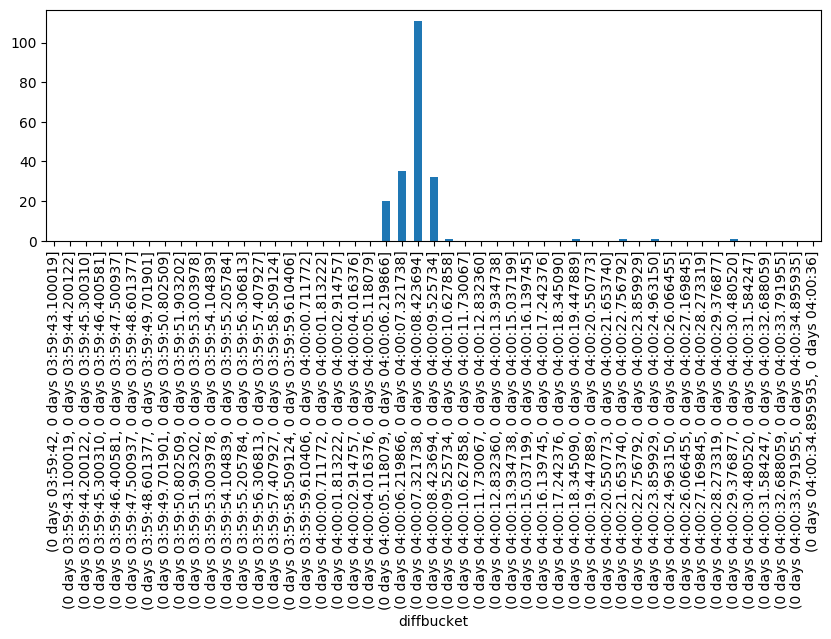

In [204]:
branc_eloggap_df['diff'] = branc_eloggap_df['datetime'] - branc_eloggap_df.shift(1)['datetime']
stpat_eloggap_df['diff'] = stpat_eloggap_df['datetime'] - stpat_eloggap_df.shift(1)['datetime']

min_lateness = 3.995*60
bins = numpy.logspace(math.log(min_lateness,10), math.log(1+stpat_eloggap_df['diff'].map(lambda x: x.total_seconds()/60).max(),10), num=120)
bins = numpy.logspace(math.log(min_lateness,10), math.log(4.01*60,10), num=50)
bins = list(map(lambda x: timedelta(minutes=x), bins))
bins
stpat_eloggap_df['diffbucket'] = pandas.cut(stpat_eloggap_df.loc[stpat_eloggap_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
# stpat_eloggap_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))
branc_eloggap_df['diffbucket'] = pandas.cut(branc_eloggap_df.loc[branc_eloggap_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
branc_eloggap_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))



In [205]:
thaloslogs_brancol_isup = pandas.read_pickle('thaloslogs_brancol_uptime_ts_df.pickle')
# thaloslogs_brancol_isup = thaloslogs_brancol_uptime_ts_df.loc[thaloslogs_brancol_uptime_ts_df['up'] == 1]
thaloslogs_brancol_isup = thaloslogs_brancol_isup.loc[thaloslogs_brancol_isup.index < '2024-04-08']
thaloslogs_brancol_isup.sort_index()
thaloslogs_brancol_isup = thaloslogs_brancol_isup.resample(timedelta(hours=4))[['up']].sum() >= 48
thaloslogs_brancol_isup

branc_eloggap_ts_df = branc_eloggap_df.set_index('datetime')
# branc_eloggap_ts_df = branc_eloggap_ts_df.resample(timedelta(minutes=5)).last()
branc_eloggap_ts_df = branc_eloggap_ts_df.resample(timedelta(hours=4)).last()
display()
branc_eloggap_ts_df = branc_eloggap_ts_df.loc[branc_eloggap_ts_df.index >= thaloslogs_brancol_isup.index[0]]
branc_eloggap_ts_df = branc_eloggap_ts_df.join(thaloslogs_brancol_isup[['up']] , how='outer')

# branc_eloggap_ts_df.loc[ ( branc_eloggap_ts_df['id'].notna() ) & ( branc_eloggap_ts_df['up'] == 1 ) ]

print('off, no vector', (( branc_eloggap_ts_df['id'].isna() ) & ( branc_eloggap_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( branc_eloggap_ts_df['id'].notna() ) & ( branc_eloggap_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( branc_eloggap_ts_df['id'].isna() ) & ( branc_eloggap_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( branc_eloggap_ts_df['id'].notna() ) & ( branc_eloggap_ts_df['up'] == 1 )).sum())
print('total on', (( branc_eloggap_ts_df['up'] == 1 )).sum())

branc_eloggap_ts_df['prevup'] = branc_eloggap_ts_df['up'].shift(1)
display(branc_eloggap_ts_df.loc[(( branc_eloggap_ts_df['id'].isna() ) & (( branc_eloggap_ts_df['up'] == 1 )) | ( branc_eloggap_ts_df['up'] != branc_eloggap_ts_df['prevup'] ) ) ])

# 27

off, no vector 369
off, vector ran somehow? 42
on, no vector? 45
on, vector worked. 132
total on 177


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,False,NaN
2024-01-06 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,False
2024-01-06 04:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-06 08:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-06 12:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-06 16:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-06 20:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-07 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-07 04:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True


In [206]:
thaloslogs_stpatrick_isup = pandas.read_pickle('thaloslogs_stpatrick_uptime_ts_df.pickle')
# thaloslogs_stpatrick_isup = thaloslogs_stpatrick_uptime_ts_df.loc[thaloslogs_stpatrick_uptime_ts_df['up'] == 1]
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.loc[thaloslogs_stpatrick_isup.index < '2024-04-08']
thaloslogs_stpatrick_isup.sort_index()
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.resample(timedelta(hours=4))[['up']].min()
thaloslogs_stpatrick_isup

stpat_eloggap_ts_df = stpat_eloggap_df.set_index('datetime')
# stpat_eloggap_ts_df = stpat_eloggap_ts_df.resample(timedelta(minutes=5)).last()
stpat_eloggap_ts_df = stpat_eloggap_ts_df.resample(timedelta(hours=4)).last()
display()
stpat_eloggap_ts_df = stpat_eloggap_ts_df.loc[stpat_eloggap_ts_df.index >= thaloslogs_stpatrick_isup.index[0]]
stpat_eloggap_ts_df = stpat_eloggap_ts_df.join(thaloslogs_stpatrick_isup[['up']] , how='outer')

# stpat_eloggap_ts_df.loc[ ( stpat_eloggap_ts_df['id'].notna() ) & ( stpat_eloggap_ts_df['up'] == 1 ) ]

print('off, no vector', (( stpat_eloggap_ts_df['id'].isna() ) & ( stpat_eloggap_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( stpat_eloggap_ts_df['id'].notna() ) & ( stpat_eloggap_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( stpat_eloggap_ts_df['id'].isna() ) & ( stpat_eloggap_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( stpat_eloggap_ts_df['id'].notna() ) & ( stpat_eloggap_ts_df['up'] == 1 )).sum())
print('total on', (( stpat_eloggap_ts_df['up'] == 1 )).sum())

stpat_eloggap_ts_df['prevup'] = stpat_eloggap_ts_df['up'].shift(1)
display(stpat_eloggap_ts_df.loc[(( stpat_eloggap_ts_df['id'].isna() ) & (( stpat_eloggap_ts_df['up'] == 1 )) | ( stpat_eloggap_ts_df['up'] != stpat_eloggap_ts_df['prevup'] ) ) ])

# 4

off, no vector 371
off, vector ran somehow? 72
on, no vector? 13
on, vector worked. 126
total on 139


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,NaN
2024-01-04 00:00:00+00:00,7211,elog time gap vector at 2024-01-04 00:27:34Z,<NA>,6,4.2180508272726654e-05,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 04:00:02.511202,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]",1,0.0
2024-01-04 08:00:00+00:00,7398,elog time gap vector at 2024-01-04 08:27:38Z,<NA>,6,9.388197584155062e-05,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 04:00:02.388921,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]",0,1.0
2024-01-04 12:00:00+00:00,7492,elog time gap vector at 2024-01-04 12:27:41Z,<NA>,6,0.0001400582964867,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 04:00:02.404082,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]",1,0.0
2024-01-05 04:00:00+00:00,7866,elog time gap vector at 2024-01-05 04:27:50Z,<NA>,6,0.0006935167447277,<NA>,<NA>,<NA>,2024-01-12 21:40:46,2024/1/12/1705095636-0.csv,d88aa954-0c8b-4c4b-9f27-f9ce5caa9534,2024,1,12,0 days 04:00:02.475018,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]",0,1.0
2024-01-05 16:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0
2024-01-05 20:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,1.0
2024-01-06 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,0,1.0
2024-01-06 12:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,1,0.0


In [207]:
(132+126) / (139-4+177-27)

0.9052631578947369

In [208]:
branc_cca_df = awswrangler.athena.read_sql_query(f"SELECT * from brancol_v1_tests where vector_id = '7'", database='tnc_edge')
branc_cca_df
branc_cca_df['datetime'] = pandas.to_datetime(branc_cca_df['datetime'], utc=True)
branc_cca_df = branc_cca_df.sort_values('datetime')

stpat_cca_df = awswrangler.athena.read_sql_query(f"SELECT * from stpatrick_v1_tests where vector_id = '7'", database='tnc_edge')
stpat_cca_df['datetime'] = pandas.to_datetime(stpat_cca_df['datetime'], utc=True)
stpat_cca_df = stpat_cca_df.sort_values('datetime')

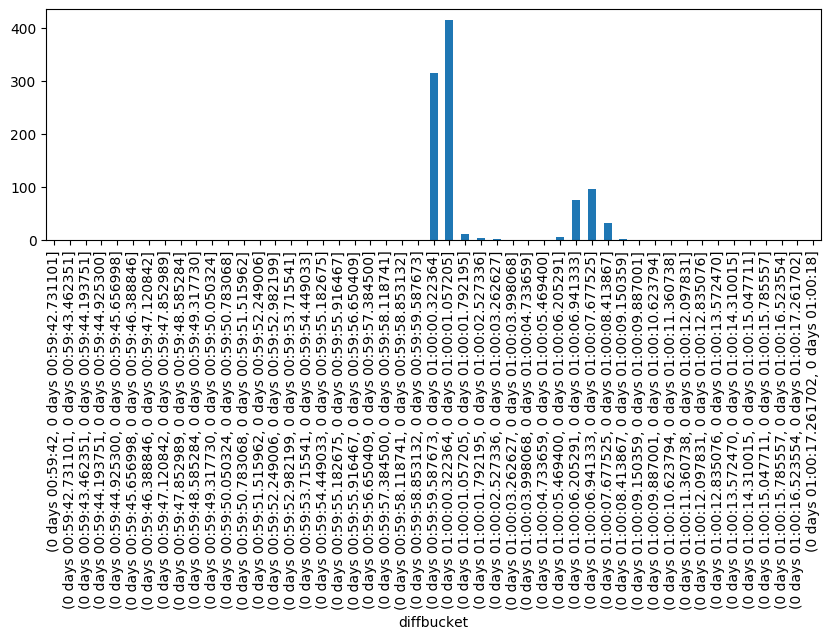

In [209]:
branc_cca_df['diff'] = branc_cca_df['datetime'] - branc_cca_df.shift(1)['datetime']
stpat_cca_df['diff'] = stpat_cca_df['datetime'] - stpat_cca_df.shift(1)['datetime']

min_lateness = 0.995*60
bins = numpy.logspace(math.log(min_lateness,10), math.log(1+stpat_cca_df['diff'].map(lambda x: x.total_seconds()/60).max(),10), num=90)
bins = numpy.logspace(math.log(min_lateness,10), math.log(1.005*60,10), num=50)
bins = list(map(lambda x: timedelta(minutes=x), bins))
bins
stpat_cca_df['diffbucket'] = pandas.cut(stpat_cca_df.loc[stpat_cca_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
# stpat_cca_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))
branc_cca_df['diffbucket'] = pandas.cut(branc_cca_df.loc[branc_cca_df['diff'] > timedelta(minutes=min_lateness)]['diff'], bins=bins)
branc_cca_df.groupby('diffbucket')['diff'].count().plot.bar(figsize=(10,3))



In [210]:
thaloslogs_brancol_isup = pandas.read_pickle('thaloslogs_brancol_uptime_ts_df.pickle')
# thaloslogs_brancol_isup = thaloslogs_brancol_uptime_ts_df.loc[thaloslogs_brancol_uptime_ts_df['up'] == 1]
thaloslogs_brancol_isup = thaloslogs_brancol_isup.loc[thaloslogs_brancol_isup.index < '2024-04-08']
thaloslogs_brancol_isup.sort_index()
thaloslogs_brancol_isup = thaloslogs_brancol_isup.resample(timedelta(hours=1))[['up']].sum() >= 10
thaloslogs_brancol_isup

branc_cca_ts_df = branc_cca_df.set_index('datetime')
# branc_cca_ts_df = branc_cca_ts_df.resample(timedelta(minutes=5)).last()
branc_cca_ts_df = branc_cca_ts_df.resample(timedelta(hours=1)).last()
display()
branc_cca_ts_df = branc_cca_ts_df.loc[branc_cca_ts_df.index >= thaloslogs_brancol_isup.index[0]]
branc_cca_ts_df = branc_cca_ts_df.join(thaloslogs_brancol_isup[['up']] , how='outer')

# branc_cca_ts_df.loc[ ( branc_cca_ts_df['id'].notna() ) & ( branc_cca_ts_df['up'] == 1 ) ]

print('off, no vector', (( branc_cca_ts_df['id'].isna() ) & ( branc_cca_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( branc_cca_ts_df['id'].notna() ) & ( branc_cca_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( branc_cca_ts_df['id'].isna() ) & ( branc_cca_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( branc_cca_ts_df['id'].notna() ) & ( branc_cca_ts_df['up'] == 1 )).sum())
print('total on', (( branc_cca_ts_df['up'] == 1 )).sum())

branc_cca_ts_df['prevup'] = branc_cca_ts_df['up'].shift(1)
display(branc_cca_ts_df.loc[(( branc_cca_ts_df['id'].isna() ) & (( branc_cca_ts_df['up'] == 1 )) | ( branc_cca_ts_df['up'] != branc_cca_ts_df['prevup'] ) ) ])

# 169

off, no vector 1236
off, vector ran somehow? 30
on, no vector? 223
on, vector worked. 863
total on 1086


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,False,NaN
2024-01-03 16:00:00+00:00,18007,catch count A test from 2024-01-02 16:50 to 20...,<NA>,7,<NA>,elog reports a flat is_fishing variable over t...,<NA>,<NA>,2024-01-03 16:51:32,2024/1/3/1704300681-0.csv,a63bcf2b-2a6e-41c3-aea9-2d5d5a18ff9a,2024,1,3,7 days 20:15:50.475992,NaN,True,False
2024-01-03 17:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,False,True
2024-01-04 16:00:00+00:00,18038,catch count A test from 2024-01-03 16:20 to 20...,<NA>,7,<NA>,elog reports a flat is_fishing variable over t...,<NA>,<NA>,2024-01-04 16:22:10,2024/1/4/1704385322-0.csv,831dcf96-e6af-4a22-84d1-7e616e231d53,2024,1,4,0 days 23:29:58.988734,NaN,True,False
2024-01-04 17:00:00+00:00,18061,catch count A test from 2024-01-03 17:20 to 20...,<NA>,7,<NA>,elog reports a flat is_fishing variable over t...,<NA>,<NA>,2024-01-04 17:21:58,2024/1/4/1704388906-0.csv,fba2b974-8656-4e31-8d2c-a8ed99a10bcf,2024,1,4,0 days 01:00:00.460936,"(0 days 01:00:00.322364, 0 days 01:00:01.057205]",False,True
2024-01-05 16:00:00+00:00,18080,catch count A test from 2024-01-04 16:51 to 20...,<NA>,7,<NA>,elog reports a flat is_fishing variable over t...,<NA>,<NA>,2024-01-05 17:52:34,2024/1/5/1704477145-0.csv,1c6aa310-3170-4e91-af5a-894d2b38d73e,2024,1,5,0 days 23:30:42.231258,NaN,True,False
2024-01-05 19:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-05 20:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-05 21:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True


In [211]:
thaloslogs_stpatrick_isup = pandas.read_pickle('thaloslogs_stpatrick_uptime_ts_df.pickle')
# thaloslogs_stpatrick_isup = thaloslogs_stpatrick_uptime_ts_df.loc[thaloslogs_stpatrick_uptime_ts_df['up'] == 1]
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.loc[thaloslogs_stpatrick_isup.index < '2024-04-08']
thaloslogs_stpatrick_isup.sort_index()
thaloslogs_stpatrick_isup = thaloslogs_stpatrick_isup.resample(timedelta(hours=1))[['up']].sum() >= 10
thaloslogs_stpatrick_isup

stpat_cca_ts_df = stpat_cca_df.set_index('datetime')
# stpat_cca_ts_df = stpat_cca_ts_df.resample(timedelta(minutes=5)).last()
stpat_cca_ts_df = stpat_cca_ts_df.resample(timedelta(hours=1)).last()
display()
stpat_cca_ts_df = stpat_cca_ts_df.loc[stpat_cca_ts_df.index >= thaloslogs_stpatrick_isup.index[0]]
stpat_cca_ts_df = stpat_cca_ts_df.join(thaloslogs_stpatrick_isup[['up']] , how='outer')

# stpat_cca_ts_df.loc[ ( stpat_cca_ts_df['id'].notna() ) & ( stpat_cca_ts_df['up'] == 1 ) ]

print('off, no vector', (( stpat_cca_ts_df['id'].isna() ) & ( stpat_cca_ts_df['up'] == 0 )).sum())
print('off, vector ran somehow?', (( stpat_cca_ts_df['id'].notna() ) & ( stpat_cca_ts_df['up'] == 0 )).sum())
print('on, no vector?', (( stpat_cca_ts_df['id'].isna() ) & ( stpat_cca_ts_df['up'] == 1 )).sum())
print('on, vector worked.', (( stpat_cca_ts_df['id'].notna() ) & ( stpat_cca_ts_df['up'] == 1 )).sum())
print('total on', (( stpat_cca_ts_df['up'] == 1 )).sum())

stpat_cca_ts_df['prevup'] = stpat_cca_ts_df['up'].shift(1)
display(stpat_cca_ts_df.loc[(( stpat_cca_ts_df['id'].isna() ) & (( stpat_cca_ts_df['up'] == 1 )) | ( stpat_cca_ts_df['up'] != stpat_cca_ts_df['prevup'] ) ) ])

# 108

off, no vector 1120
off, vector ran somehow? 79
on, no vector? 150
on, vector worked. 976
total on 1126


,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket,up,prevup
datetime,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,False,NaN
2024-01-03 14:00:00+00:00,6980,catch count A test from 2024-01-02 14:12 to 20...,<NA>,7,<NA>,elog reports a flat is_fishing variable over t...,<NA>,<NA>,2024-01-03 15:13:56,2024/1/3/1704294826-0.csv,e2d23f44-a544-470d-bc3f-d76b6ef18351,2024,1,3,22 days 22:29:55.951031,NaN,True,False
2024-01-05 05:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,False,True
2024-01-05 13:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,False
2024-01-05 14:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-05 15:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-05 16:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-05 17:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True
2024-01-05 18:00:00+00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,True,True


In [212]:
# off, no vector 1236
# off, vector ran somehow? 30
# on, no vector? 223
# on, vector worked. 863
# total on 1086

# 169

# off, no vector 1120
# off, vector ran somehow? 79
# on, no vector? 150
# on, vector worked. 976
# total on 1126

# 108

# (863+976)/(1186-169+1126-108)
(863+976)/(1086-169+1126-108)

0.9503875968992248

In [213]:
tmp = stpat_eloggap_df.set_index('datetime')
tmp.sort_index()

,id,name,type,vector_id,score,detail,datetime_from,datetime_to,md_timestamp_added,md_file_name,md_ingest_uuid,partition_0,partition_1,partition_2,diff,diffbucket
datetime,,,,,,,,,,,,,,,,
2023-11-29 09:08:04.032061+00:00,3612,elog time gap vector at 2023-11-29 09:08:04Z,<NA>,6,0.0050843785839849,<NA>,<NA>,<NA>,2023-11-29 09:09:03,2023/11/29/1701248931-0.csv,b1ea5277-da6c-489e-b412-e07eae26eb85,2023,11,29,NaT,NaN
2023-11-29 13:08:06.896342+00:00,3702,elog time gap vector at 2023-11-29 13:08:06Z,<NA>,6,0.0075666294758672,<NA>,<NA>,<NA>,2023-11-29 13:10:41,2023/11/29/1701263429-0.csv,32aa0f04-99ca-4b16-b948-1f9bc227a913,2023,11,29,0 days 04:00:02.864281,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]"
2023-11-29 17:08:09.244329+00:00,3792,elog time gap vector at 2023-11-29 17:08:09Z,<NA>,6,0.0112469568347352,<NA>,<NA>,<NA>,2023-11-29 17:12:01,2023/11/29/1701277909-0.csv,c697b047-095f-4c01-9669-250ad51e97a6,2023,11,29,0 days 04:00:02.347987,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]"
2023-11-30 15:13:24.763721+00:00,3933,elog time gap vector at 2023-11-30 15:13:24Z,<NA>,6,0.0103807381821556,<NA>,<NA>,<NA>,2023-11-30 15:14:29,2023/11/30/1701357258-0.csv,cf3007af-78ee-4ffe-8deb-df41f34a3ebc,2023,11,30,0 days 22:05:15.519392,NaN
2023-11-30 19:13:27.289763+00:00,4023,elog time gap vector at 2023-11-30 19:13:27Z,<NA>,6,0.0103807381821556,<NA>,<NA>,<NA>,2023-11-30 19:15:51,2023/11/30/1701371738-0.csv,e3af346a-e4a2-41cc-a52e-60892a6645f4,2023,11,30,0 days 04:00:02.526042,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]"
2023-12-01 09:05:22.190603+00:00,4153,elog time gap vector at 2023-12-01 09:05:22Z,<NA>,6,0.0103807381821556,<NA>,<NA>,<NA>,2023-12-01 09:06:33,2023/12/1/1701421581-0.csv,7cc6e5c1-83d3-4e73-97b3-4c2f6b6ec648,2023,12,1,0 days 13:51:54.900840,NaN
2023-12-01 13:05:24.780254+00:00,4243,elog time gap vector at 2023-12-01 13:05:24Z,<NA>,6,0.0103807381821556,<NA>,<NA>,<NA>,2023-12-01 13:08:48,2023/12/1/1701436116-0.csv,efbc9d2e-9d78-4dc3-8095-44ffd65393f3,2023,12,1,0 days 04:00:02.589651,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]"
2023-12-01 17:05:26.991179+00:00,4333,elog time gap vector at 2023-12-01 17:05:26Z,<NA>,6,0.0103807381821556,<NA>,<NA>,<NA>,2023-12-01 17:10:20,2023/12/1/1701450607-0.csv,b842b93a-e208-456d-90f5-b7bb69c1bb2b,2023,12,1,0 days 04:00:02.210925,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]"
2023-12-01 21:05:29.255570+00:00,4422,elog time gap vector at 2023-12-01 21:05:29Z,<NA>,6,0.0103807381821556,<NA>,<NA>,<NA>,2023-12-01 21:11:37,2023/12/1/1701465085-0.csv,10b0cfc1-31e4-4236-8b8a-fccd53606105,2023,12,1,0 days 04:00:02.264391,"(0 days 04:00:01.813222, 0 days 04:00:02.914757]"
